<a href="https://colab.research.google.com/github/Bindhya-K/NLP/blob/main/TextClassification_using_BERT_tensorflow_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall tensorflow


Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.14.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.14.0


In [2]:
!pip install tensorflow==2.13.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 45.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

In [3]:
!pip install --upgrade tensorflow-hub

In [3]:
import tensorflow_hub as hub
!pip install --upgrade tensorflow-text
import tensorflow_text as text

In [4]:
bert_preprocessor_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [5]:
text = ['nice movie','I had a great time spending with you']
pre_processed_text = bert_preprocessor_model(text)

In [6]:
pre_processed_text.keys()

dict_keys(['input_mask', 'input_word_ids', 'input_type_ids'])

Text classification from spam dataset

In [7]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


In [8]:
import io
df = pd.read_csv(io.BytesIO(uploaded['spam.csv']),encoding='latin-1')

In [9]:
df = df.rename(columns={'v1':'Category','v2':'Message'})
df=df.loc[:,['Category','Message']]
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

Imbalnace data

In [11]:
#Downsample
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']
df_ham_downsample = df_ham.sample(df_spam.shape[0])
df_ham_downsample.shape

(747, 2)

In [12]:
df_spam.shape

(747, 2)

In [13]:
df_balanced = pd.concat([df_ham_downsample,df_spam])

In [14]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df_balanced.head()

,Category,Message,spam
3023,ham,I love ya too but try and budget your money be...,0
2888,ham,My battery is low babe,0
1561,ham,Dnt worry...use ice pieces in a cloth pack.als...,0
734,ham,Leaving to qatar tonite in search of an opport...,0
3535,ham,Oic cos me n my sis got no lunch today my dad ...,0


In [15]:
# Splitting into training and test data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [16]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocessor_model(sentences)
    return bert_encoder_model(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.51327264, -0.8884571 , ..., -0.7474883 ,
        -0.7531474 ,  0.91964495],
       [-0.87208354, -0.50543964, -0.9444669 , ..., -0.85847515,
        -0.7174534 ,  0.88082975]], dtype=float32)>

In [17]:
# functional model
import tensorflow as tf
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocessor_model(text_input)
outputs = bert_encoder_model(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [19]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [20]:
# Train the model
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 402s 11s/step - loss: 0.6206 - accuracy: 0.6848 - precision: 0.6858 - recall: 0.6821
Epoch 2/10
35/35 [==============================] - 354s 10s/step - loss: 0.5039 - accuracy: 0.8205 - precision: 0.8188 - recall: 0.8232
Epoch 3/10
35/35 [==============================] - 355s 10s/step - loss: 0.4334 - accuracy: 0.8491 - precision: 0.8308 - recall: 0.8768
Epoch 4/10
35/35 [==============================] - 353s 10s/step - loss: 0.3829 - accuracy: 0.8795 - precision: 0.8583 - recall: 0.9089
Epoch 5/10
35/35 [==============================] - 350s 10s/step - loss: 0.3546 - accuracy: 0.8839 - precision: 0.8812 - recall: 0.8875
Epoch 6/10
35/35 [==============================] - 349s 10s/step - loss: 0.3313 - accuracy: 0.8920 - precision: 0.8791 - recall: 0.9089
Epoch 7/10
35/35 [==============================] - 347s 10s/step - loss: 0.3125 - accuracy: 0.8973 - precision: 0.8910 - recall: 0.9054
Epoch 8/10
35/35 [=======================

In [21]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 119s 10s/step - loss: 0.2741 - accuracy: 0.9171 - precision: 0.9333 - recall: 0.8984


[0.27405381202697754,
 0.9171122908592224,
 0.9333333373069763,
 0.8983957171440125]

In [22]:
y_predicted = model.predict(X_test)

y_predicted = y_predicted.flatten()
y_predicted

12/12 [==============================] - 117s 10s/step


array([0.04290767, 0.20180735, 0.83030915, 0.06970295, 0.80769444,
       0.10043329, 0.9444471 , 0.51685077, 0.9136467 , 0.05935792,
       0.88578945, 0.8289936 , 0.87070745, 0.03352887, 0.83221996,
       0.06054509, 0.965164  , 0.92325526, 0.11336233, 0.7131808 ,
       0.25031012, 0.0272846 , 0.69018507, 0.8669359 , 0.76339597,
       0.15412195, 0.15937552, 0.8672954 , 0.7303678 , 0.0289134 ,
       0.56571543, 0.16214281, 0.46756482, 0.18452571, 0.10517517,
       0.95346695, 0.21849   , 0.9665877 , 0.95509017, 0.8552682 ,
       0.12949827, 0.4442177 , 0.05046675, 0.779897  , 0.24466604,
       0.9015482 , 0.7191975 , 0.75052565, 0.65393907, 0.20274001,
       0.01295744, 0.06674378, 0.0375723 , 0.49300793, 0.7728476 ,
       0.7466288 , 0.48141414, 0.03575863, 0.16770442, 0.97517735,
       0.06014819, 0.27490634, 0.43514872, 0.8590678 , 0.8943338 ,
       0.02154002, 0.23034753, 0.9021796 , 0.9054577 , 0.22377703,
       0.8172041 , 0.72486275, 0.6751457 , 0.70845824, 0.62915

In [23]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[175,  12],
       [ 19, 168]])

Text(50.722222222222214, 0.5, 'Truth')

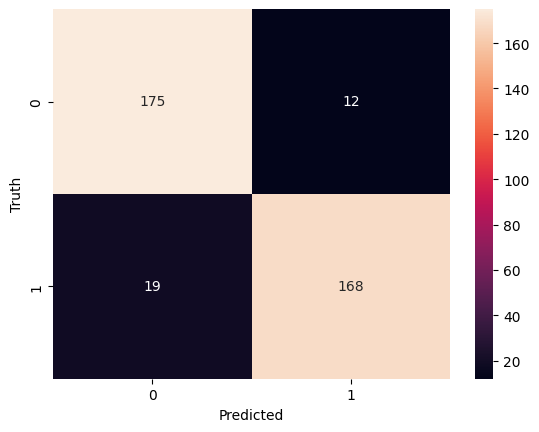

In [25]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [26]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       187
           1       0.93      0.90      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



In [30]:
test = ['Hi how are you?','Win $ 1000 &*price ticket by planning a trip to malayasia. get free entry ','your resume got shortlisted']
model.predict(test)

1/1 [==============================] - 2s 2s/step


array([[0.02449641],
       [0.6249593 ],
       [0.01772309]], dtype=float32)